In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os import path
import sys, inspect
current_dir = path.dirname(path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


from nu_aesthetics.single_colors import brand, design
from matplotlib.cm import register_cmap


from support.shared_consts import *
from support.utils import *

# Model

$Y = \beta_0 + \beta_1 x_1 + \dots + \beta_k x_k + \epsilon$

$\epsilon_i$ i.i.d. $N(0, 1)$

$E = Y - \hat{Y}$

## Canonical X

$Y = 6 + 1.3 x + \epsilon$

$\epsilon_i$ i.i.d. $N(0, 1)$

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     373.7
Date:                Tue, 25 May 2021   Prob (F-statistic):           1.57e-54
Time:                        13:10:35   Log-Likelihood:                -1599.5
No. Observations:                 300   AIC:                             3203.
Df Residuals:                     298   BIC:                             3210.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.6801      3.360      2.285      0.0

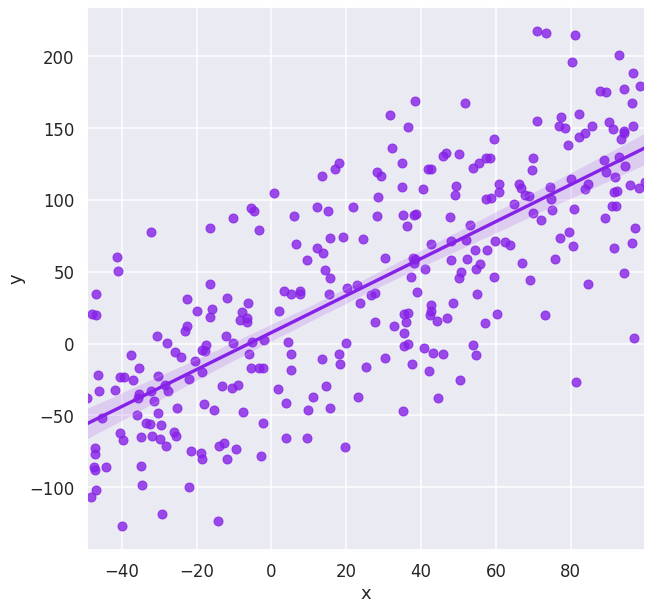

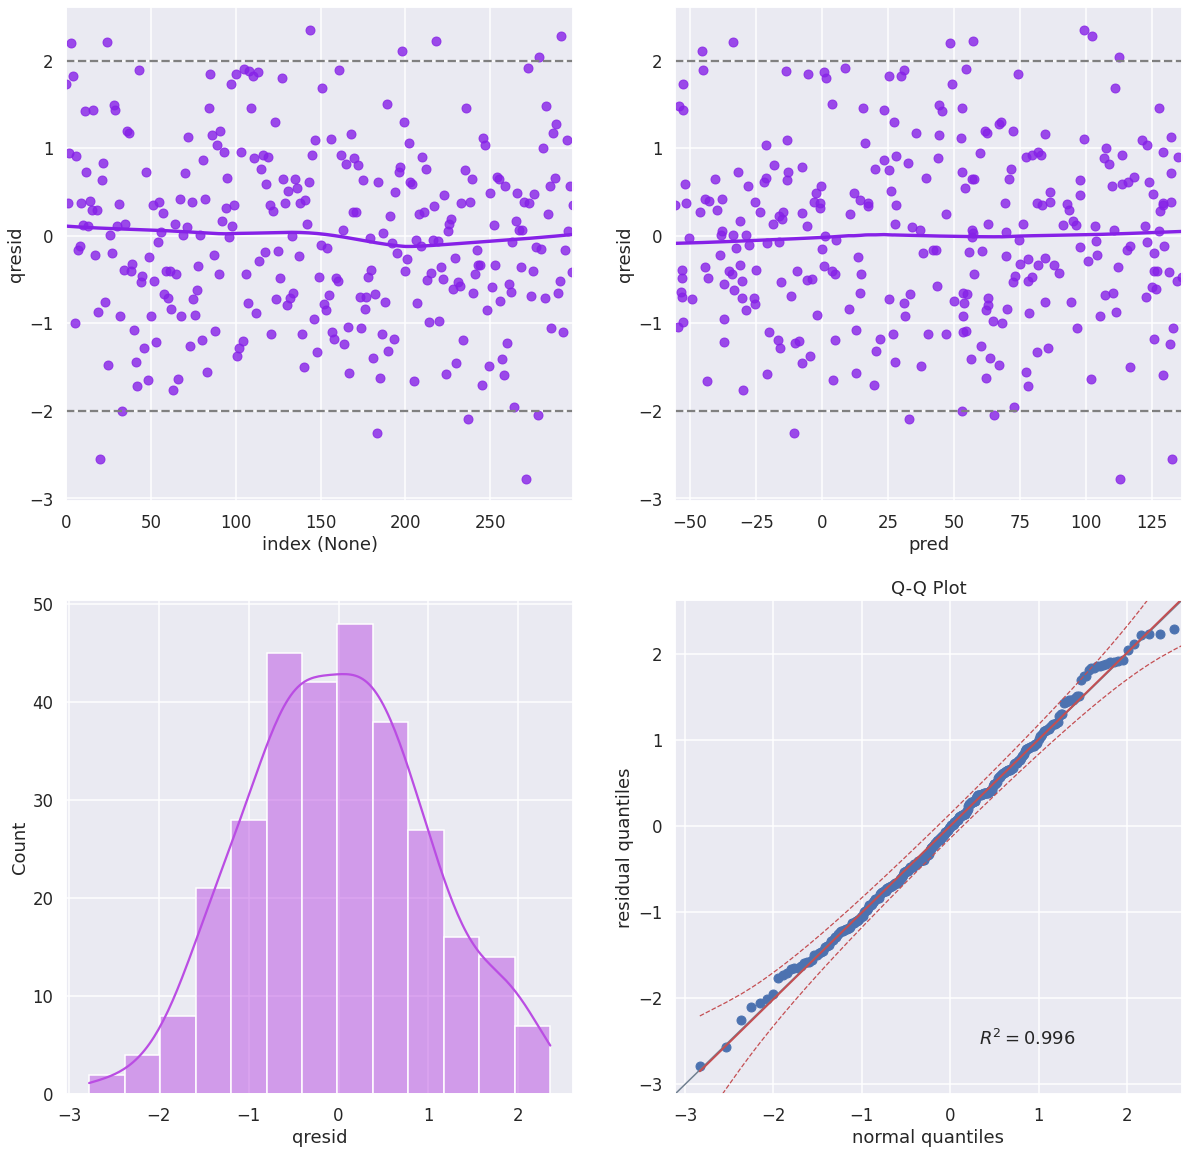

In [3]:
x = x_fix.copy()
e = e_fix.copy()
y = y_fix.copy()
data = pd.DataFrame({"x": x, "e": e, "y": y})

regressor = smf.ols(formula="y ~ x", data=data).fit()
print(regressor.summary())
ax = plot_lmreg(data=data)
plt.savefig(f"../imgs/simul_model_canonical.png", bbox_inches="tight")
plt.show()

data["pred"] = predict(regressor, data)
plot_resid(regressor, data)
plt.savefig(f"../imgs/simul_resid_canonical.png", bbox_inches="tight")
plt.show()

## Model validity

Normality: the OLS is `robust`, having its `validity` even when their assumptions are false - hypothesis tests and confidence intervals are approximately correct for **non-normal large samples**.<br/>
The OLS might not be `efficient`, specially for **heavy-tailed** distributed errors.  
When the errors have a **skewed distribution**, the mean is no more a good measure of centrality and this compromises the `interpretation` of the OLS coefficients even though they might be valid. The remedy to this is usually a transformation on $Y$ to make it more symmetrical.

**Non linearity on covariate**

$Y = 6 + 1.3 x ^2 + \epsilon$

Model: y ~ x


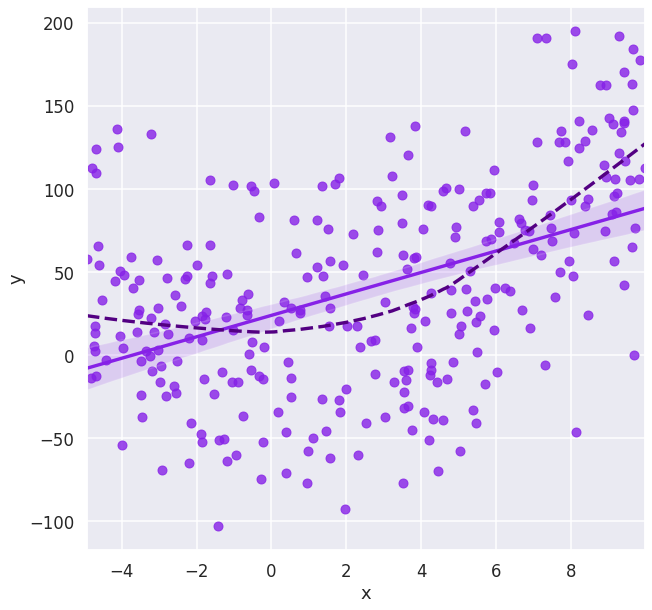

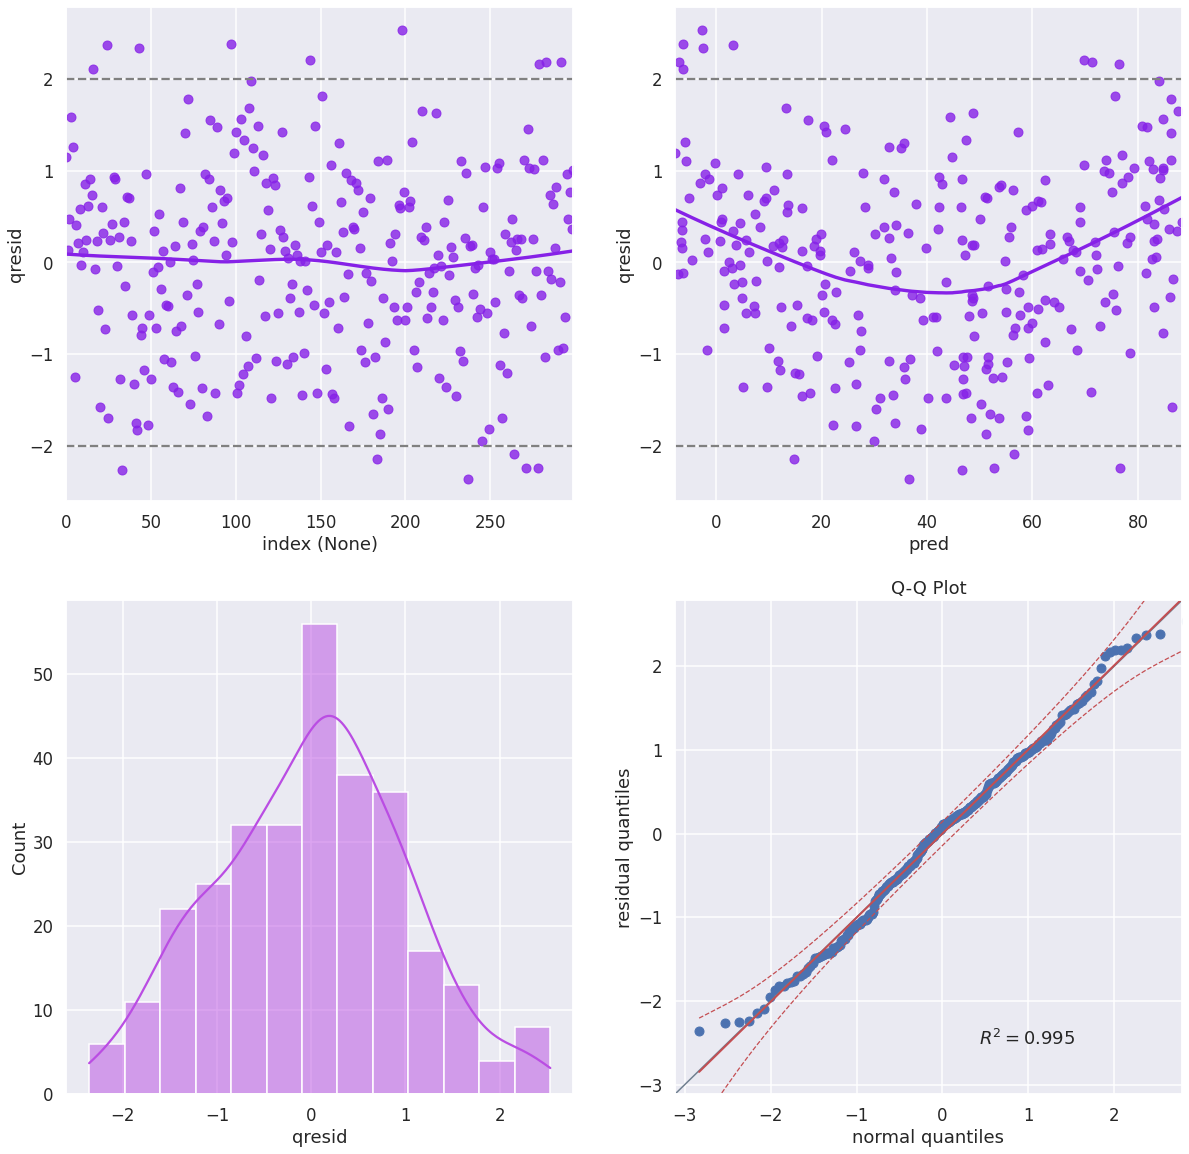

Model: y ~ x**2


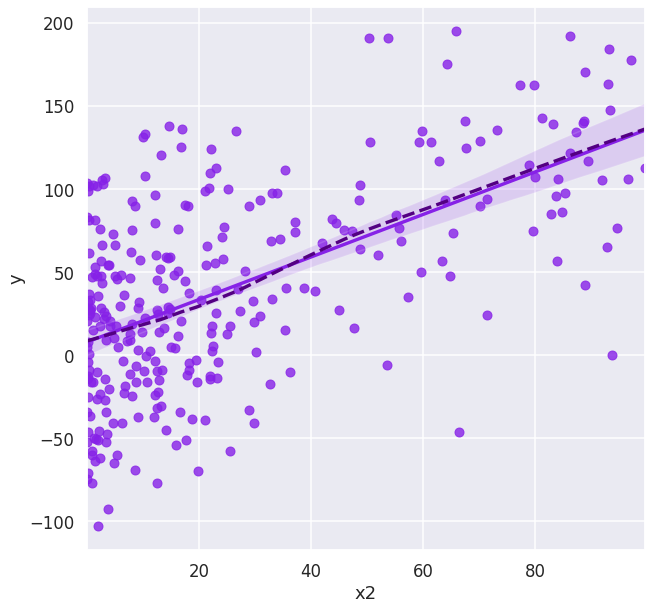

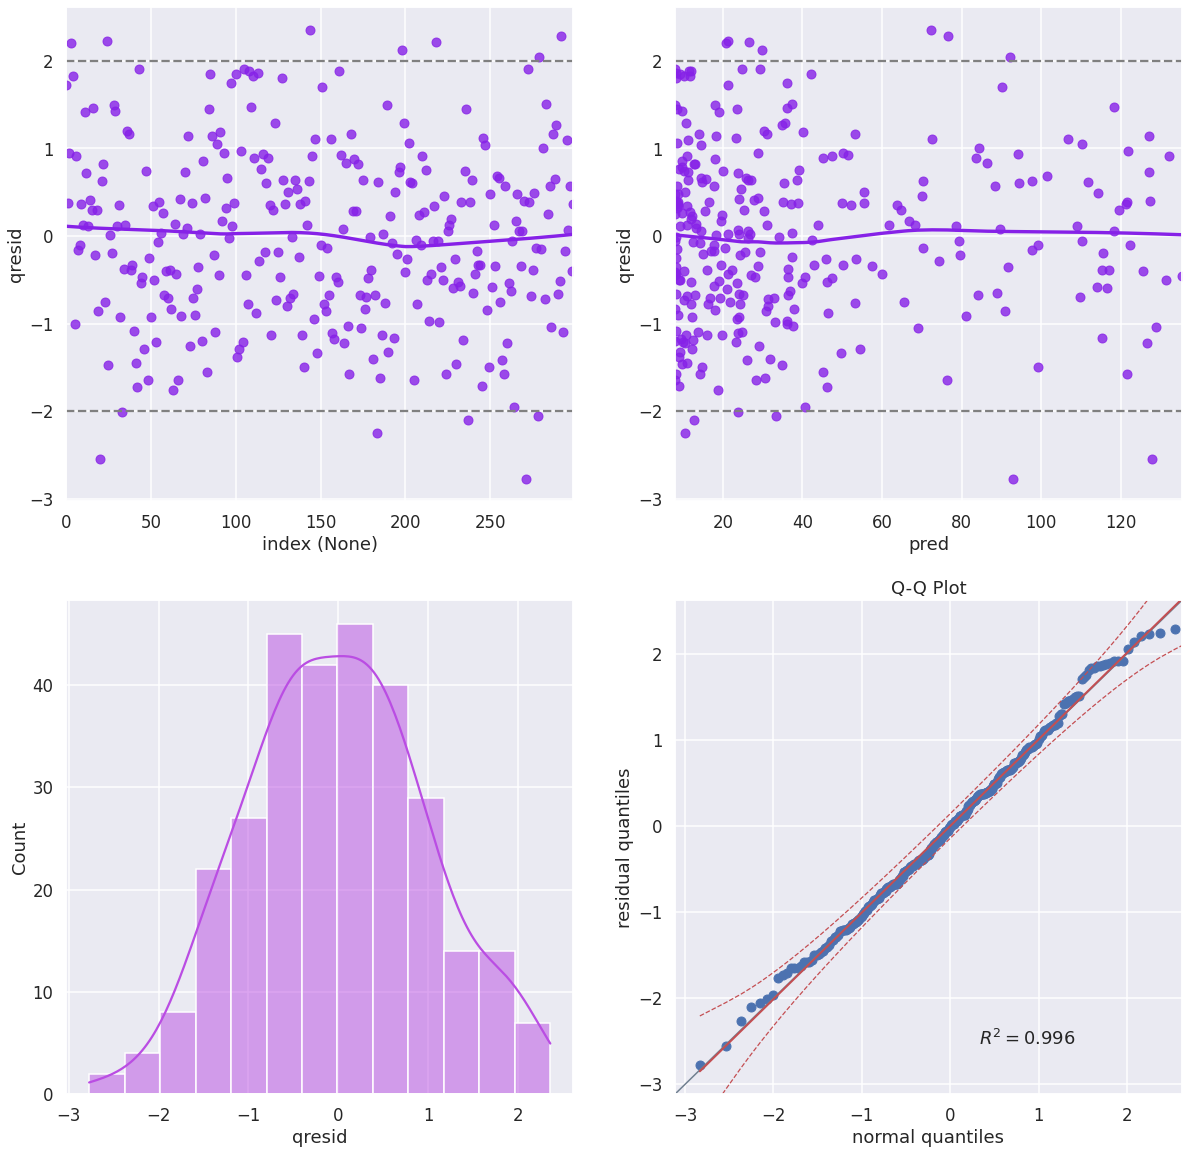

In [4]:
x = x_fix.copy() / 10
e = e_fix.copy()
y = true_params["b0"] + true_params["b1"] * x**2 + e
data = pd.DataFrame({"x": x, "e": e, "y": y})

print("Model: y ~ x")
regressor = smf.ols(formula="y ~ x", data=data).fit()
ax = plot_lmreg(data=data, x="x", y="y", lowess=True)
plt.savefig(f"../imgs/simul_model_nonlin_cov_false.png", bbox_inches="tight")
plt.show()
data["pred"] = predict(regressor, data)
plot_resid(regressor, data)
plt.savefig(f"../imgs/simul_resid_nonlin_cov_false.png", bbox_inches="tight")
plt.show()


print("Model: y ~ x**2")
data["x2"] = data["x"]**2
regressor = smf.ols(formula="y ~ x2", data=data).fit()
ax = plot_lmreg(data=data, x="x2", y="y", lowess=True)
plt.savefig(f"../imgs/simul_model_nonlin_cov_true.png", bbox_inches="tight")
plt.show()
data["pred"] = predict(regressor, data, x="x2")
plot_resid(regressor, data, x="x2")
plt.savefig(f"../imgs/simul_resid_nonlin_cov_true.png", bbox_inches="tight")
plt.show()

**Non linearity on response**

$Y^2 = 6 + 1.3 x + \epsilon$

Model: y ~ x


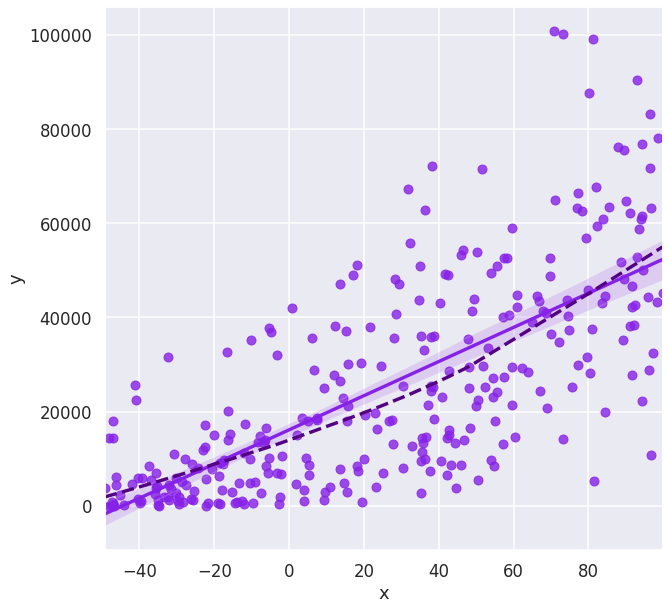

In [ ]:
setting = "canonical"

x = x_fix.copy()
e = e_fix.copy()
y = 100+true_params["b0"] + true_params["b1"] * x + e
y = y**2
data = pd.DataFrame({"x": x, "e": e, "y": y})

print("Model: y ~ x")
regressor = smf.ols(formula="y ~ x", data=data).fit()
ax = plot_lmreg(data=data, x="x", y="y", lowess=True)
plt.savefig(f"../imgs/simul_model_nonlin_y_false.png", bbox_inches="tight")
plt.show()
data["pred"] = predict(regressor, data)
data["qresid"] = calculate_qresid(regressor, data)
plot_resid(regressor, data)
plt.savefig(f"../imgs/simul_resid_nonlin_y_false.png", bbox_inches="tight")
plt.show()


print("Model: sqrt(y) ~ x")
data["sqrt_y"] = np.sqrt(data["y"])
regressor = smf.ols(formula="sqrt_y ~ x", data=data).fit()
ax = plot_lmreg(data=data, x="x", y="sqrt_y", lowess=True)
plt.savefig(f"../imgs/simul_model_nonlin_y_true.png", bbox_inches="tight")
plt.show()
data["pred"] = predict(regressor, data)
data["qresid"] = calculate_qresid(regressor, data, y="sqrt_y")
plot_resid(regressor, data, y="sqrt_y")
plt.savefig(f"../imgs/simul_resid_nonlin_y_true.png", bbox_inches="tight")
plt.show()

**Non independent**

Positive-correlated data in a same with independent data between days.

In [ ]:
x = x_fix.copy()
data = pd.DataFrame({"x": x, "e": None, "y": None})
data["date"] = pd.Series(range(n//5)).sample(n, replace=True, random_state=0).values
for idx, [group, df_group] in enumerate(data.groupby("date")):
    m = len(df_group)
    cov = np.full((m, m), 0.9 * true_params["scale"]**2)
    np.fill_diagonal(cov, true_params["scale"]**2)
    np.random.seed(idx)
    data.loc[data["date"] == group, "e"] = np.random.multivariate_normal(np.zeros(m), cov, 1)[0]
#     e = np.random.normal(0, true_params["scale"], 1)
#     np.random.seed(seed)
#     data.loc[data["date"] == group, "e"] = e + np.random.normal(0, true_params["scale"]/2, m)
data["y"] = true_params["b0"] + true_params["b1"] * data["x"] + data["e"]
data = data.astype("float")

print("Model: y ~ x")
regressor = smf.ols(formula="y ~ x", data=data).fit()
print(regressor.summary())
ax = plot_lmreg(data=data, x="x", y="y")
plt.savefig(f"../imgs/simul_model_dep.png", bbox_inches="tight")
plt.show()
data["pred"] = predict(regressor, data)
plot_resid(regressor, data.set_index("date"))
plt.savefig(f"../imgs/simul_resid_dep.png", bbox_inches="tight")
plt.show()


print("Model: y ~ x; aggregated residuals")
regressor = smf.ols(formula="y ~ x", data=data).fit()
print(regressor.summary())
ax = plot_lmreg(data=data, x="x", y="y")
plt.savefig(f"../imgs/simul_model_dep_agg.png", bbox_inches="tight")
plt.show()
data["pred"] = predict(regressor, data)
data = data.groupby("date").mean()
plot_resid(regressor, data.set_index("x"))
plt.savefig(f"../imgs/simul_resid_dep_agg.png", bbox_inches="tight")
plt.show()


print("Model: y ~ date")
data = data.groupby("date").mean().reset_index()
regressor = smf.ols(formula="y ~ date", data=data).fit()
print(regressor.summary())
ax = plot_lmreg(data=data, x="date", y="y", lowess=True)
plt.savefig(f"../imgs/simul_model_dep_date.png", bbox_inches="tight")
plt.show()
data["pred"] = predict(regressor, data, x="date")
plot_resid(regressor, data.set_index("date"), x="date")
plt.savefig(f"../imgs/simul_resid_dep_date.png", bbox_inches="tight")
plt.show()

**Non-constant variance**

In [ ]:
setting = "canonical"

x = x_fix.copy()
e = e_fix.copy()
mu = 100 + true_params["b1"] * x
e = (mu)**0.5 * e
y = true_params["b0"] + true_params["b1"] * x + e
data = pd.DataFrame({"x": x, "e": e, "y": y})

print("Model: y ~ x")
regressor = smf.ols(formula="y ~ x", data=data).fit()
ax = plot_lmreg(data=data, x="x", y="y")
sns.regplot(x="x",y="y", data=data, ax=ax,
            lowess=True, scatter=False,
            color=brand.NU_DARK_PURPLE_MATPLOT, line_kws={"linestyle": "--"})
plt.savefig(f"../imgs/simul_model_nonconst_var.png", bbox_inches="tight")
plt.show()
data["pred"] = predict(regressor, data)
data["qresid"] = calculate_qresid(regressor, data)
plot_resid(regressor, data)
plt.savefig(f"../imgs/simul_model_nonconst_var.png", bbox_inches="tight")
plt.show()